
# Description

Runs power simulations to produce Figure 1.

# Imports

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from ipywidgets import interact_manual
from linearmodels.iv import IV2SLS
from scipy.stats import norm
from scipy.special import logit
from sklearn.base import clone
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from tqdm import tqdm

import sys

# user imports
sys.path.append("../")

from utils.pwr import rdd_power
from utils.sim import create_covariates, generate_IV_comply_indicator

## Matplotlib setup

In [4]:
# matplotlib config
%matplotlib inline

matplotlib.rcParams['figure.dpi'] = 300

# Simulation data functions

In [6]:
formula = 'Y ~ 1 + [T ~ Z]'

def simulation(n, tau, prop_comply, n_trials, exclude_criteria=None, confound_str=0.8):
    """
    Conducts multiple trials of simulated data.
    
    Args:
        n (int): number of samples
        tau (float): treatment effect
        prop_comply (float): proportion of compliers
        n_trials (int): number of trials to run
        exclude_criteria (str): optionally specify the type of exclusion strategy: 
            - 'TneqZ': known non-compliers
            - 'comply': true compliance status
        confound_str (float): the strength of the confounder
    
    Returns:
        tuple of lists per trial: 
            - estimated treatment effect (tau_hats)
            - power (pwrs)
            - number excluded (n_excluded)
            - empirical variance (var_hats)
    """
    pwrs = []
    tau_hats = []
    n_excluded = []
    var_hats = []
    
    for trial in range(n_trials):
        prop_nt = (1 - prop_comply) / 2
        prop_at = (1 - prop_comply) / 2
        #df = generate_IV(n, tau, prop_comply, trial, confound_str)
        df = generate_IV_comply_indicator(n, tau, 
                                          prop_nt=prop_nt, prop_at=prop_at, 
                                          seed=trial, C_T=confound_str)
        
        if exclude_criteria == "TneqZ":
            sel_df = df[df['T'] == df['Z']]
        elif exclude_criteria == "comply":
            sel_df = df[df['X'] == 1]
        elif exclude_criteria is None:
            sel_df = df
            
        iv_model = IV2SLS.from_formula(formula, sel_df)
        iv_results = iv_model.fit(cov_type='robust')
        var = iv_results.std_errors['T']**2
        tau_hat = iv_results.params['T']
        
        pwr = rdd_power(tau, var)
        pwrs.append(pwr)
        tau_hats.append(tau_hat)
        var_hats.append(var)
        
        n_excluded.append(df.shape[0] - sel_df.shape[0])

    return tau_hats, pwrs, var_hats, n_excluded

In [7]:
def plot_results(tau, tau_hats, pwrs, var_hats, n_exclude):
    """Plots the results from a given call to simulation()"""
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), dpi=150)
    sns.boxplot(data=tau_hats, ax=ax1, orient='h')
    ax1.axvline(tau, color='black', ls='--', label="true treatment effect", )
    ax1.set_xlim(tau - 1.5, tau + 1.5)
    ax1.legend()
    ax1.set_ylabel("Est. treatment effect")

    sns.boxplot(data=pwrs, color='green', ax=ax2, orient='h')
    ax2.set_xlim(0, 1)
    ax2.set_ylabel("Est. power")
    
    
    sns.boxplot(data=var_hats, color='red', ax=ax3, orient='h')
    ax3.set_xlim(0, 0.5)
    ax3.set_ylabel("Std. errors")

    
    sns.boxplot(data=n_exclude, color='orange', ax=ax4, orient='h')
    ax4.set_ylabel("Num excluded")

# Run simulation

In [8]:
n_samples = 1000
num_trials = 100
tau = 0.5

n_exclude = np.arange(0,901, 50)

exclude_list = []
complier_pwr_list = []
hat_pwr_list = []
var_list = []
target_effect_list = []
trial_list = []
comply_list = []
tau_list = []

compliances = [0.2, 0.4, 0.6]

formula = 'Y ~ 1+ [T ~ Z]'
for i in tqdm(range(num_trials)):
    #print(i)
    for p_compliance in compliances:
        p_at = (1 - p_compliance) / 2
        p_nt = (1 - p_compliance) / 2
        
        df = generate_IV_comply_indicator(seed=i, 
                                       n_samples=n_samples, 
                                       tau=tau,
                                       prop_at=p_at,
                                       prop_nt=p_nt)
        df = df.sort_values('X', ascending=False)
        
        for excl in n_exclude:
            trial_list.append(i)
            exclude_list.append(excl)
            comply_list.append(p_compliance)
            
            sel_df = df.head(int(n_samples-excl))
            ctl = sel_df[sel_df['T'] == 0]
            effect = np.std(ctl['Y']) / 2
            target_effect_list.append(effect)
            
            iv_model = IV2SLS.from_formula(formula, sel_df)
            iv_results = iv_model.fit(cov_type='robust')
            var = iv_results.std_errors['T']**2
            tau_hat = iv_results.params['T']
            var_list.append(var)
            tau_list.append(tau_hat)
            
            pwr = rdd_power(tau, var)
            #pwr = iv_power(sel_df, tau)
            complier_pwr_list.append(pwr)
            

 38%|███▊      | 38/100 [00:25<00:40,  1.53it/s]/home/tliu/.conda/envs/rdd/lib/python3.7/site-packages/linearmodels/shared/linalg.py:68: RuntimeWarning: divide by zero encountered in true_divide
  return vecs @ np.diag(1 / np.sqrt(vals)) @ vecs.T
/home/tliu/.conda/envs/rdd/lib/python3.7/site-packages/linearmodels/shared/linalg.py:68: RuntimeWarning: invalid value encountered in matmul
  return vecs @ np.diag(1 / np.sqrt(vals)) @ vecs.T
/home/tliu/.conda/envs/rdd/lib/python3.7/site-packages/linearmodels/iv/model.py:588: RuntimeWarning: invalid value encountered in matmul
  q = vpmzv_sqinv @ (ex1.T @ ex1) @ vpmzv_sqinv
100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


# Figure 1: power curve plot

In [11]:
pwr_unif_df = pd.DataFrame()
pwr_unif_df['n_exclude'] = exclude_list
pwr_unif_df['trial'] = trial_list
pwr_unif_df['complier_pwr'] = complier_pwr_list
pwr_unif_df['frac_comply'] = comply_list
pwr_unif_df['fraction compliers'] = pwr_unif_df['frac_comply'] 

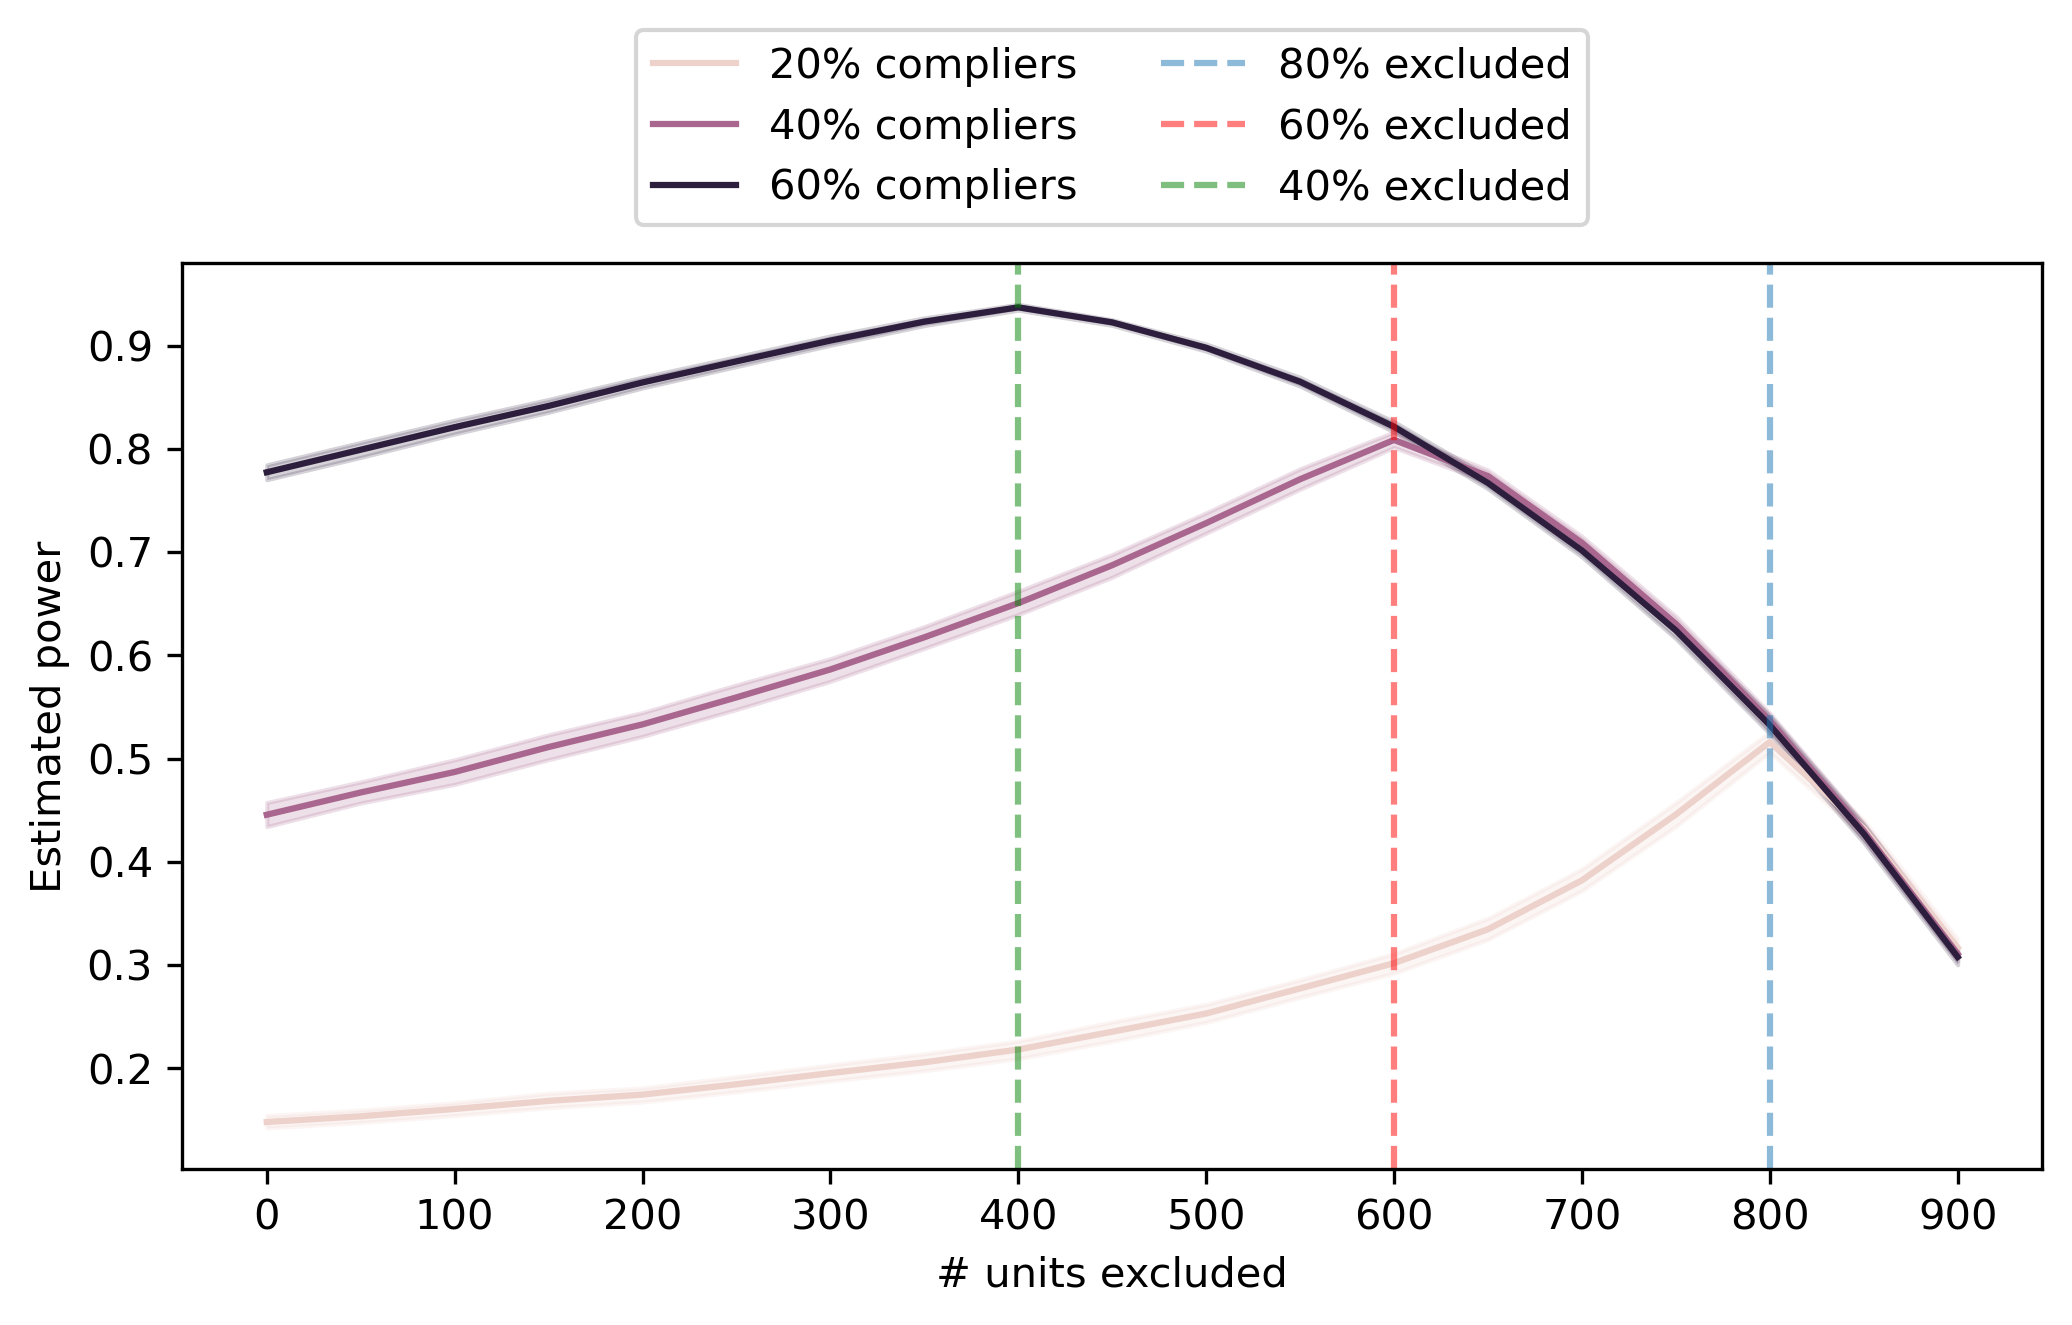

In [12]:
sns.lineplot(x='n_exclude', y='complier_pwr', data=pwr_unif_df, hue='fraction compliers', legend='full')
plt.axvline(x=800, label="80% excluded", ls='--', alpha=0.5)
plt.axvline(x=600, label="60% excluded", ls='--', color="r", alpha=0.5)
plt.axvline(x=400, label="40% excluded", ls='--', color='g', alpha=0.5)

plt.xticks(np.arange(0,1000,100))
legend = plt.legend(loc="center", ncol=2, bbox_to_anchor=(0.5, 1.15))
legend.get_texts()[0].set_text('20% compliers')
legend.get_texts()[1].set_text('40% compliers')
legend.get_texts()[2].set_text('60% compliers')
plt.ylabel("Estimated power")
plt.xlabel("# units excluded")

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 4)

#plt.savefig("../figures/pwr_known_comply.png", bbox_inches='tight')

## Simplified power plot for presentations

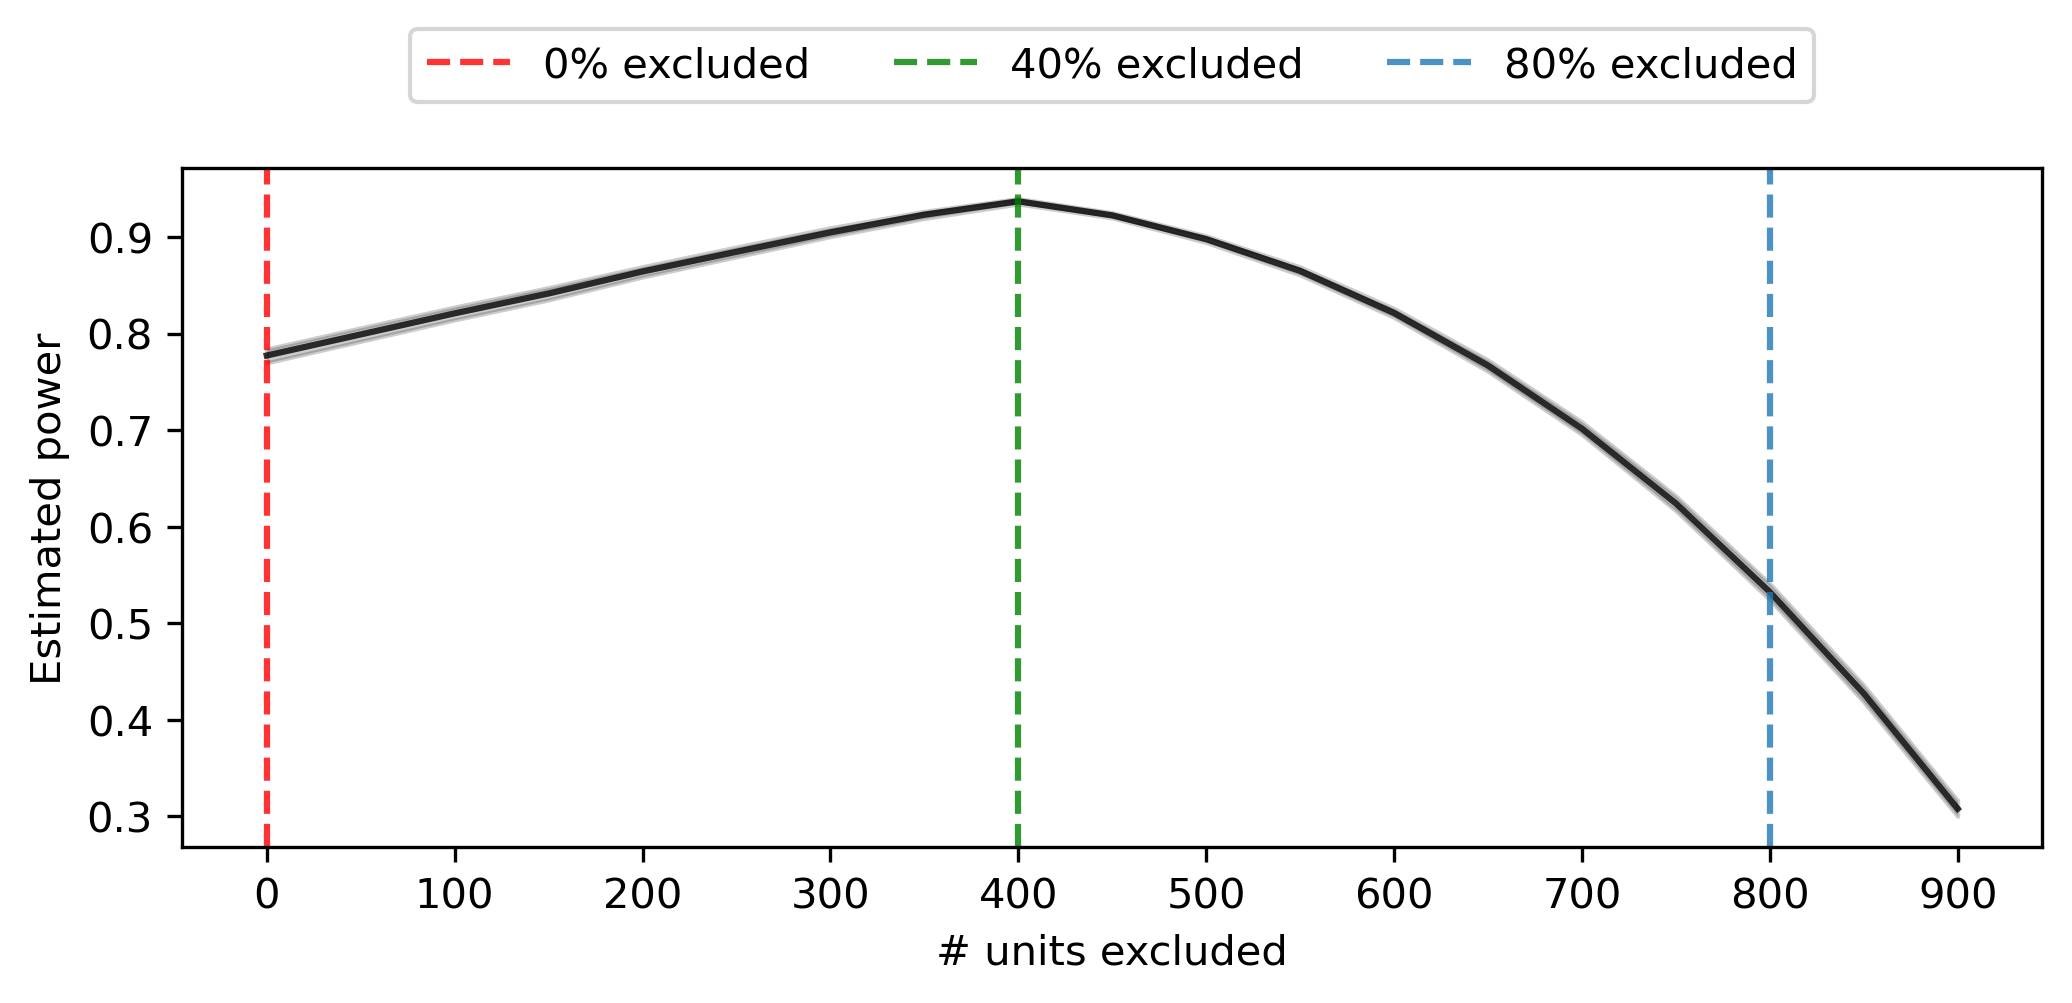

In [13]:
sel_df = pwr_unif_df[pwr_unif_df['frac_comply'] == 0.6]

sns.lineplot(x='n_exclude', y='complier_pwr', data=sel_df, 
             #hue='fraction compliers', 
             alpha=0.8,
             color='black',
             legend=None)
plt.axvline(x=0, label="0% excluded", ls='--', color="r", alpha=0.8)
plt.axvline(x=400, label="40% excluded", ls='--', color='g', alpha=0.8)
plt.axvline(x=800, label="80% excluded", ls='--', alpha=0.8)



plt.xticks(np.arange(0,1000,100))
legend = plt.legend(loc="center", ncol=3, bbox_to_anchor=(0.5, 1.15))
#legend.get_texts()[0].set_text('20% compliers')
#legend.get_texts()[1].set_text('40% compliers')
#legend.get_texts()[0].set_text('60% compliers')
plt.ylabel("Estimated power")
plt.xlabel("# units excluded")

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 3)